In [1]:
import torch 
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchsummary import summary
from tqdm.notebook import tqdm


C:\Users\Samba\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Samba\AppData\Local\Programs\Python\Python39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device using: ',device)
if device != 'cpu':
    print(torch.cuda.get_device_name())

Device using:  cuda
NVIDIA GeForce GTX 1050


In [3]:
dataset = ImageFolder('../dataset',transform=transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels=1)]))
print('Length of the dataset is ',len(dataset))
print('Classes',dataset.classes, '\nNumber of classes: ',len(dataset.classes))

Length of the dataset is  6831
Classes ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] 
Number of classes:  26


In [4]:
image,label = dataset[0]
image.shape , label , dataset.classes[label]

(torch.Size([1, 34, 34]), 0, 'A')

Label Z Image shape: torch.Size([1, 34, 34])


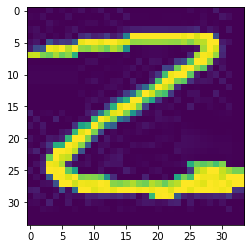

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt 

def display(data):
    image,label = data 
    plt.imshow(image.permute(1,2,0))
    print(f'Label {dataset.classes[label]} Image shape: {image.shape}')
display(dataset[-187])


In [6]:
o = lambda i,k,p=0,s=1: (i+2*p-k)//s +1 
o(16,3) , 32/2

(14, 16.0)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.conv1 = nn.Conv2d(1,6,3) # out 32
        self.pool1 = nn.MaxPool2d(2,2) # out 16
        self.conv2 = nn.Conv2d(6,16,3) # out 14
        self.pool2 = nn.MaxPool2d(2,2) # out 7
        self.conv3 = nn.Conv2d(16,26,3) # out 5
        self.fc1 = nn.Linear(25*26,26)
        # self.fc2 = nn.Linear(128,26)
    
    def forward(self,x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool1(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool2(x)
        x = nn.functional.relu(self.conv3(x))
        x = x.view(-1,25*26)
        x = self.fc1(x)
        # x = self.fc2(x)
        # x1 = nn.functional.softmax(x)

        return x 



In [8]:
 21636/len(dataset)

3.1673254281949936

In [9]:
model = Net().to(device)
summary(model,(1,34,34))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]              60
         MaxPool2d-2            [-1, 6, 16, 16]               0
            Conv2d-3           [-1, 16, 14, 14]             880
         MaxPool2d-4             [-1, 16, 7, 7]               0
            Conv2d-5             [-1, 26, 5, 5]           3,770
            Linear-6                   [-1, 26]          16,926
Total params: 21,636
Trainable params: 21,636
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.08
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


In [10]:
criterion = nn.CrossEntropyLoss()
learning_rate = 3e-4
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [11]:
def training_process(model,device,trainloader,valoader,criterion,optimizer):
    model.train()
    running_loss  = 0
    Ncorrect_predictions = 0 # number of correct prediction
    total = 0
    for images,labels in tqdm(trainloader):
        images,labels = images.to(device), labels.to(device)
        # moving the data to GPU
        optimizer.zero_grad()
        out = model(images)
        loss_per_batch = criterion(out,labels)
        total += labels.size(0) # basically this should return the batch size
        preds = torch.argmax(out,1).cpu().detach()
        running_loss +=loss_per_batch.item()
        Ncorrect_predictions += (preds==labels.cpu().detach()).sum().item()
        
        loss_per_batch.backward() # back propagation algorithm
        optimizer.step()

    acc = 100*(Ncorrect_predictions/total)
    avg_loss = running_loss/len(trainloader)

    model.eval()
    total_ = 0
    correct_ = 0
    running_loss_ = 0
    with torch.no_grad():
        for images,labels in tqdm(valoader):
            out = model(images.to(device))
            labels = labels.to(device)
            loss = criterion(out,labels)
            running_loss_ += loss 
            total_ += labels.size(0)
            predictions = out.argmax(dim=1).cpu().detach()
            correct_ += (predictions==labels.cpu().detach()).sum().item()
    
    val_loss = running_loss_/len(valoader)
    val_acc = 100*(correct_/total_)

    return acc,avg_loss,val_loss,val_acc

    

In [12]:
S = len(dataset)
S*0.7,S*0.1,S*0.2,S

(4781.7, 683.1, 1366.2, 6831)

In [13]:

train,val,test = torch.utils.data.random_split(dataset, [4781,684,1366])
len(train), len(val), len(test)
batch = 256
trainDL = DataLoader(train,batch,shuffle=True,num_workers=4)
valDL = DataLoader(val,batch,shuffle=False,num_workers=4)
# testDL = DataLoader(test,batch,shuffle=False,num_workers=4)
len(trainDL),len(valDL)

(19, 3)

In [14]:
train_losses=[]
valid_losses= []
accuracy=[]
v=[]
for i in range(100):
    acc,avg_loss,val_loss,val_acc = training_process(model,device,trainDL,valDL,criterion,optimizer)
    print(f'Epoch{i+1}\nTrain: acc {acc} loss {avg_loss}\nVal: acc{val_acc} loss {val_loss}')
    train_losses.append(avg_loss)
    valid_losses.append(val_loss)
    accuracy.append(acc)
    v.append(val_acc)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch1
Train: acc 5.563689604685212 loss 3.247095045290495
Val: acc4.5321637426900585 loss 3.231261730194092


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch2
Train: acc 6.086592763020288 loss 3.187342831962987
Val: acc5.701754385964912 loss 3.1481473445892334


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch3
Train: acc 10.311650282367706 loss 3.0359147724352384
Val: acc20.614035087719298 loss 2.898763656616211


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch4
Train: acc 36.059401798786865 loss 2.64299255923221
Val: acc54.385964912280706 loss 2.2975478172302246


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch5
Train: acc 62.53921773687513 loss 1.91860672674681
Val: acc65.78947368421053 loss 1.5475504398345947


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch6
Train: acc 68.70947500522904 loss 1.3350770849930613
Val: acc69.00584795321637 loss 1.2105917930603027


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch7
Train: acc 71.9514745869065 loss 1.1157714912765904
Val: acc70.02923976608187 loss 1.100298523902893


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch8
Train: acc 73.60384856724535 loss 1.0182553121918125
Val: acc73.24561403508771 loss 1.019152045249939


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch9
Train: acc 75.69546120058565 loss 0.9589241617604306
Val: acc74.26900584795322 loss 0.9697558283805847


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch10
Train: acc 77.09684166492366 loss 0.9030589335843137
Val: acc74.56140350877193 loss 0.9280068874359131


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch11
Train: acc 78.03806734992679 loss 0.86908379353975
Val: acc75.58479532163743 loss 0.9019696116447449


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch12
Train: acc 78.70738339259569 loss 0.8384818277860943
Val: acc76.46198830409357 loss 0.8793458938598633


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch13
Train: acc 80.04601547793348 loss 0.8070798139823111
Val: acc76.60818713450293 loss 0.8484115600585938


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch14
Train: acc 79.98326709893327 loss 0.7813419636927152
Val: acc78.50877192982456 loss 0.8204994201660156


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch15
Train: acc 81.36373143693788 loss 0.7488900266195598
Val: acc77.77777777777779 loss 0.7981542348861694


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch16
Train: acc 81.4683120686049 loss 0.7325938406743502
Val: acc78.80116959064327 loss 0.7850451469421387


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch17
Train: acc 82.49320225894165 loss 0.7059636178769564
Val: acc79.3859649122807 loss 0.7661428451538086


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch18
Train: acc 83.35076343861117 loss 0.6865178597600836
Val: acc80.11695906432749 loss 0.750604510307312


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch19
Train: acc 83.45534407027819 loss 0.6719900385329598
Val: acc81.14035087719299 loss 0.7427572011947632


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch20
Train: acc 83.87366659694625 loss 0.6515272071487025
Val: acc81.28654970760235 loss 0.7319949865341187


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch21
Train: acc 84.50115038694834 loss 0.6370354812396201
Val: acc80.99415204678363 loss 0.7181012630462646


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch22
Train: acc 85.14955030328383 loss 0.6128970259114316
Val: acc82.30994152046783 loss 0.6901259422302246


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch23
Train: acc 85.6306212089521 loss 0.5945350119942113
Val: acc82.16374269005848 loss 0.6856076121330261


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch24
Train: acc 86.00711148295336 loss 0.5767349475308469
Val: acc82.89473684210526 loss 0.6629738211631775


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch25
Train: acc 86.53001464128843 loss 0.5590733807337912
Val: acc82.89473684210526 loss 0.6523714661598206


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch26
Train: acc 86.57184689395524 loss 0.5495835150543013
Val: acc82.60233918128655 loss 0.6411805152893066


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch27
Train: acc 87.03200167329011 loss 0.5340560862892553
Val: acc83.33333333333334 loss 0.6346204280853271


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch28
Train: acc 87.57582095795858 loss 0.5148829127612867
Val: acc83.91812865497076 loss 0.6165825724601746


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch29
Train: acc 87.82681447395943 loss 0.4971974680298253
Val: acc84.94152046783626 loss 0.5996801853179932


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch30
Train: acc 88.30788537962769 loss 0.4833041366777922
Val: acc84.35672514619883 loss 0.5897377729415894


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch31
Train: acc 88.97720142229659 loss 0.4695666573549572
Val: acc84.50292397660819 loss 0.5872403383255005


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch32
Train: acc 88.91445304329638 loss 0.45635570036737544
Val: acc85.08771929824562 loss 0.5678949952125549


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch33
Train: acc 89.56285295963188 loss 0.44055336400082235
Val: acc85.23391812865498 loss 0.562685489654541


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch34
Train: acc 89.93934323363312 loss 0.4267513155937195
Val: acc85.38011695906432 loss 0.5543057918548584


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch35
Train: acc 90.46224639196821 loss 0.41047276634919017
Val: acc85.52631578947368 loss 0.5399320721626282


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch36
Train: acc 90.60865927630203 loss 0.39910661860516194
Val: acc86.25730994152046 loss 0.531814455986023


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch37
Train: acc 90.92240117130308 loss 0.3839891599981408
Val: acc86.11111111111111 loss 0.5172637701034546


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch38
Train: acc 91.36163982430455 loss 0.37384555684892756
Val: acc86.25730994152046 loss 0.5122718214988708


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch39
Train: acc 91.52896883497176 loss 0.36580838027753326
Val: acc86.98830409356725 loss 0.5013678669929504


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch40
Train: acc 91.90545910897302 loss 0.35116828350644363
Val: acc86.8421052631579 loss 0.4973962903022766


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch41
Train: acc 92.07278811964025 loss 0.34175168369945724
Val: acc86.69590643274854 loss 0.49016904830932617


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch42
Train: acc 92.07278811964025 loss 0.32940829898181717
Val: acc87.28070175438597 loss 0.4865627884864807


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch43
Train: acc 92.03095586697344 loss 0.3229214666705382
Val: acc87.71929824561403 loss 0.4718860983848572


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch44
Train: acc 92.95126542564317 loss 0.3094615677469655
Val: acc88.30409356725146 loss 0.4654929041862488


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch45
Train: acc 92.63752353064213 loss 0.30259916970604345
Val: acc87.57309941520468 loss 0.47374427318573


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch46
Train: acc 93.03492993097679 loss 0.2913791505913985
Val: acc87.71929824561403 loss 0.4685535132884979


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch47
Train: acc 93.22317506797742 loss 0.2819786212946239
Val: acc87.71929824561403 loss 0.45224952697753906


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch48
Train: acc 93.66241372097888 loss 0.2730831801891327
Val: acc88.74269005847954 loss 0.459477037191391


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch49
Train: acc 93.74607822631249 loss 0.26330129880654185
Val: acc88.45029239766082 loss 0.44890734553337097


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch50
Train: acc 93.74607822631249 loss 0.25755924143289266
Val: acc88.88888888888889 loss 0.4369252622127533


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch51
Train: acc 94.20623300564735 loss 0.2458135015086124
Val: acc89.47368421052632 loss 0.43037647008895874


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch52
Train: acc 93.8924911106463 loss 0.24059032688015386
Val: acc88.88888888888889 loss 0.43153440952301025


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch53
Train: acc 94.60363940598201 loss 0.22986851632595062
Val: acc88.30409356725146 loss 0.4314272105693817


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch54
Train: acc 94.5618071533152 loss 0.22713719543657804
Val: acc89.47368421052632 loss 0.42065000534057617


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch55
Train: acc 95.08471031165028 loss 0.21259999745770505
Val: acc89.32748538011695 loss 0.42307043075561523


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch56
Train: acc 94.91738130098307 loss 0.2139601142782914
Val: acc90.05847953216374 loss 0.4192243218421936


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch57
Train: acc 94.95921355364987 loss 0.20760968837298846
Val: acc89.91228070175438 loss 0.4190707802772522


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch58
Train: acc 95.29387157498431 loss 0.19953539810682597
Val: acc89.47368421052632 loss 0.41536903381347656


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch59
Train: acc 95.18929094331729 loss 0.19873368112664475
Val: acc89.61988304093568 loss 0.42067667841911316


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch60
Train: acc 95.52394896465175 loss 0.1884878811083342
Val: acc89.91228070175438 loss 0.4081892967224121


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch61
Train: acc 95.81677473331939 loss 0.17986088638242922
Val: acc89.61988304093568 loss 0.4022502601146698


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch62
Train: acc 95.79585860698599 loss 0.17690431993258626
Val: acc89.47368421052632 loss 0.4094642102718353


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch63
Train: acc 95.8376908596528 loss 0.17021108026567258
Val: acc90.35087719298247 loss 0.39816874265670776


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch64
Train: acc 95.98410374398661 loss 0.16461685888077082
Val: acc89.76608187134502 loss 0.4004470109939575


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch65
Train: acc 96.25601338632084 loss 0.1624808774182671
Val: acc90.64327485380117 loss 0.41078871488571167


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch66
Train: acc 96.15143275465384 loss 0.1576570711637798
Val: acc90.35087719298247 loss 0.4009271562099457


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch67
Train: acc 96.42334239698808 loss 0.15080825553128593
Val: acc90.49707602339181 loss 0.40433555841445923


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch68
Train: acc 96.23509725998744 loss 0.15024486105693013
Val: acc90.78947368421053 loss 0.3935302197933197


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch69
Train: acc 96.5488391549885 loss 0.1426016766774027
Val: acc90.49707602339181 loss 0.39241522550582886


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch70
Train: acc 96.61158753398871 loss 0.13750350396884115
Val: acc90.35087719298247 loss 0.42316722869873047


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch71
Train: acc 96.63250366032212 loss 0.1344003265625552
Val: acc90.2046783625731 loss 0.4043278396129608


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch72
Train: acc 97.09265843965697 loss 0.12679103801124975
Val: acc90.35087719298247 loss 0.3957563638687134


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch73
Train: acc 96.84166492365614 loss 0.1256771307242544
Val: acc90.35087719298247 loss 0.4162777364253998


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch74
Train: acc 96.98807780798995 loss 0.12512834801485664
Val: acc90.64327485380117 loss 0.4035807251930237


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch75
Train: acc 97.02991006065676 loss 0.11929864279533688
Val: acc89.91228070175438 loss 0.4095931053161621


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch76
Train: acc 97.05082618699016 loss 0.11715430178140339
Val: acc90.64327485380117 loss 0.4153594374656677


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch77
Train: acc 97.32273582932442 loss 0.11204590726839869
Val: acc90.64327485380117 loss 0.4121952950954437


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch78
Train: acc 97.51098096632504 loss 0.10619914257212688
Val: acc90.05847953216374 loss 0.4175987243652344


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch79
Train: acc 97.49006483999163 loss 0.10666902951504055
Val: acc90.64327485380117 loss 0.423683226108551


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch80
Train: acc 97.46914871365823 loss 0.10179159613816362
Val: acc90.49707602339181 loss 0.41716480255126953


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch81
Train: acc 97.67830997699227 loss 0.10076694896346644
Val: acc90.64327485380117 loss 0.40148019790649414


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch82
Train: acc 97.67830997699227 loss 0.0970617579786401
Val: acc89.76608187134502 loss 0.4122392535209656


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch83
Train: acc 97.67830997699227 loss 0.09316637406223699
Val: acc90.64327485380117 loss 0.41749095916748047


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch84
Train: acc 97.76197448232587 loss 0.09314913341873571
Val: acc90.64327485380117 loss 0.4132390022277832


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch85
Train: acc 97.9920518719933 loss 0.08361380880600527
Val: acc90.05847953216374 loss 0.41388773918151855


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch86
Train: acc 97.9293034929931 loss 0.08483417743915006
Val: acc90.93567251461988 loss 0.4273821711540222


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch87
Train: acc 97.86655511399289 loss 0.08588324330354992
Val: acc90.49707602339181 loss 0.44141286611557007


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch88
Train: acc 98.18029700899393 loss 0.08136730621519841
Val: acc90.93567251461988 loss 0.4394550025463104


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch89
Train: acc 98.0129679983267 loss 0.07944524935201595
Val: acc90.35087719298247 loss 0.4481332302093506


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch90
Train: acc 98.09663250366032 loss 0.07926260503499132
Val: acc90.35087719298247 loss 0.42681384086608887


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch91
Train: acc 98.28487764066095 loss 0.07476200947636052
Val: acc91.37426900584795 loss 0.4316936433315277


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch92
Train: acc 98.32670989332776 loss 0.07080191393431864
Val: acc90.35087719298247 loss 0.4457724988460541


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch93
Train: acc 98.28487764066095 loss 0.06854720060762606
Val: acc89.61988304093568 loss 0.4339143633842468


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch94
Train: acc 98.49403890399499 loss 0.06524991146043728
Val: acc90.49707602339181 loss 0.4487985074520111


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch95
Train: acc 98.57770340932859 loss 0.0636281667179183
Val: acc90.49707602339181 loss 0.4542403221130371


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch96
Train: acc 98.38945827232797 loss 0.06278270561444133
Val: acc90.05847953216374 loss 0.4527381658554077


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch97
Train: acc 98.5149550303284 loss 0.06113561340852788
Val: acc91.22807017543859 loss 0.4494059085845947


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch98
Train: acc 98.66136791466221 loss 0.058326009857027156
Val: acc89.18128654970761 loss 0.4658653736114502


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch99
Train: acc 98.6195356619954 loss 0.05655176721905407
Val: acc89.91228070175438 loss 0.4538268446922302


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch100
Train: acc 98.6404517883288 loss 0.05728569254279137
Val: acc90.49707602339181 loss 0.4567452073097229


In [15]:
def plot(nb_epochs,train_losses,valid_losses,acc,v):
    epochs = range(nb_epochs)
    plt.plot(epochs, train_losses, 'g', label='Training loss')
    plt.plot(epochs, valid_losses, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.plot(epochs, acc, 'g', label='Training accuracy')
    plt.plot(epochs, v, 'b', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

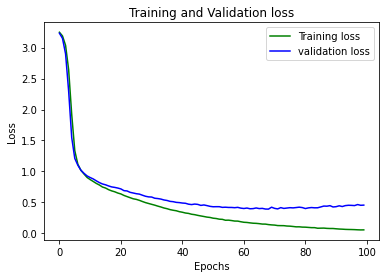

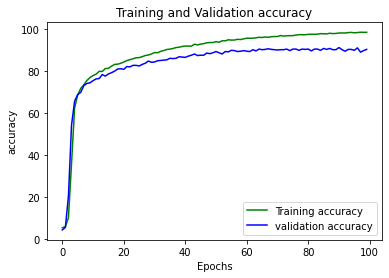

In [16]:

plot(100,train_losses,[v.cpu() for v in valid_losses],accuracy,v)

In [17]:
torch.save(model.state_dict,'abc.pth')

In [20]:
def Final_test(dataloader,model,loss_fn):

#     model in evaluation mode
    model.eval() 
    
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad(): # gradients calculation not required
        
        for x,y in dataloader:
            
            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            
    avg_loss = running_loss/len(dataloader) #Average loss per batch.      
    val_acc = 100*(correct/total)
    print(f'\t test Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on test set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    


In [19]:
testDL = DataLoader(test,batch,shuffle=False,num_workers=4)

Final_test(testDL,model,criterion)

	 test Loss = 0.552344	Accuracy on test set = 91.288433% [1247/1366]
avg_loss 0.5523439000050226 val_acc 91.28843338213763
